<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-records" data-toc-modified-id="Get-records-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get records</a></span></li><li><span><a href="#Show-annotations" data-toc-modified-id="Show-annotations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Show annotations</a></span></li></ul></div>

In [1]:
from mantisshrimp.all import *

In [2]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [3]:
class PersonImageParser(ImageParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        # Get size
        sz = self.lines.filter(lambda o: o.startswith('Image size (X x Y x C)'))[0]
        sz = re.search(r'\d{3,4}\sx\s\d{3,4}\sx\s3', sz).group()
        self.sz = lmap(int, sz.split('x'))
        
    def iid(self, o): return self.i
    def file_path(self, o):
        fp = self.lines.filter(lambda o: o.startswith('Image filename'))[0]
        fp = re.findall(r'"(.*)"', fp)[0]
        return self.source.parent/fp
    
    def width(self, o):  return self.sz[0]
    def height(self, o): return self.sz[1]

In [4]:
class PersonAnnotationParser(AnnotationParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        ln = self.lines.filter(lambda o: o.startswith('Objects with ground truth'))[0]
        self.n = int(re.findall('\d+', ln)[0])
        
    def iid(self, o): return self.i
    def oid(self, o): return [1]*self.n
    def iscrowd(self, o): return [0]*self.n
        
    def bbox(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Bounding box'))
        bboxes = []
        for bbox in lines:
            bbox = re.findall(r'(\d+,\s\d+)', bbox)
            bbox = lmap(lambda o: lmap(int, o.split(',')), bbox)
            bbox = np.array(bbox).flat
            bboxes.append(BBox.from_xyxy(*bbox))
        return bboxes
    
    def seg(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Pixel mask for object'))
        line = lines[0] # All lines contain the same mask
        fp = self.source.parent/re.findall(r'"(.+)"', line.split(':')[-1])[0]
        return MaskFile(fp)

In [5]:
class PersonParser(DataParser):
    def get_img_parser(self, o, source): return PersonImageParser(o, source)
    def get_annot_parser(self, o, source): return PersonAnnotationParser(o, source)

In [6]:
fns = get_files(source/'Annotation', extensions='.txt')

In [7]:
id2cat = {1: 'person'}

In [8]:
parser = PersonParser(fns, source)
train,valid = parser.parse()


Removed 0 images that don't have annotations


## Get records

In [9]:
# grid(partial(show_record, bbox=True, id2cat=id2cat), train[42:45])

In [10]:
tfms = AlbumentationTransformer([A.HorizontalFlip(p=.5)])

In [11]:
ds_train = Dataset(train, tfms)
ds_valid = Dataset(valid)

In [12]:
@patch
def to_erle(self:MaskFile, h, w): return self.to_mask(h,w).to_erle(h,w)

In [13]:
@patch
def to_erle(self:Mask,h,w): 
    return mask_utils.encode(np.asfortranarray(self.data.transpose(1,2,0)))

In [14]:
coco_ds = coco_api_from_records(valid, id2cat)


creating index...
index created!


In [15]:
model = MaskRCNNModel(2)

In [16]:
# TODO: Create new evaluator each validation?
model.coco_evaluator = COCOEvaluator(model, coco_ds)

In [17]:
dl_train = RCNNDataloader(ds_train, batch_size=2)
dl_valid = RCNNDataloader(ds_valid, batch_size=4)

In [18]:
catIds = coco_ds.getCatIds(catNms=['person'])
imgIds = coco_ds.getImgIds(catIds=catIds)
img = coco_ds.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [19]:
trainer = pl.Trainer(max_epochs=2, gpus=0)

INFO:lightning:GPU available: True, used: False


In [ ]:
trainer.fit(model, dl_train, dl_valid)

INFO:lightning:
    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 43 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
model.freeze()

In [ ]:
record = records[0]

In [ ]:
im = open_img(record.iinfo.fp)

In [ ]:
res = model([im2tensor(im).cuda()])[0]

In [ ]:
r2 = record.new(annot=dict(
    bboxes=[BBox.from_xyxy(*o) for o in res['boxes']],
    segs=Mask((res['masks']>.5).long().squeeze().cpu().numpy()),
))

In [ ]:
show_record(r2, bbox=False)

## Show annotations

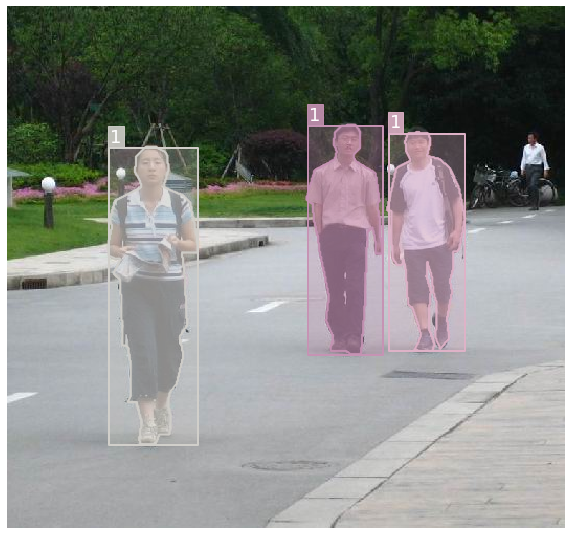

In [9]:
show_record(valid[13])

In [11]:
show_annot(im, labels, bboxes, masks)

NameError: name 'im' is not defined